# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

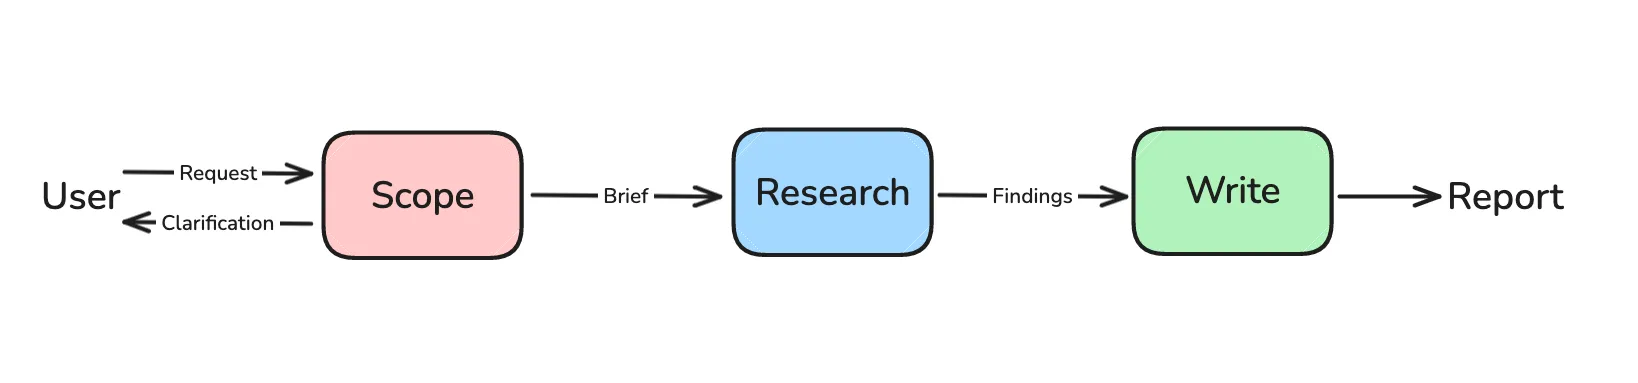

Let's build an agent that is capable of performing research on a given research brief.

## Agents for Research

Research is an open‑ended task; the best strategy to answer a user request can’t be easily known in advance. Requests can require different research strategies and varying levels of search depth. Consider this request:

> *“Compare these two products”*

Comparisons typically benefit from search on each product, followed by a synthesis step to compare them. Now, consider this one:

> *“Is X really true?”*

Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.
 
[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

## Agent with Custom Tools

Let's define an [agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) that will call custom search tools in a loop:

1. **LLM Call**: The model decides whether to call a tool or provide a final answer
2. **Tool Execution**: If tools are called, they are executed and results are gathered
3. **Iteration**: The model receives tool results and decides next steps
4. **Termination**: The loop continues until the model decides it has enough information

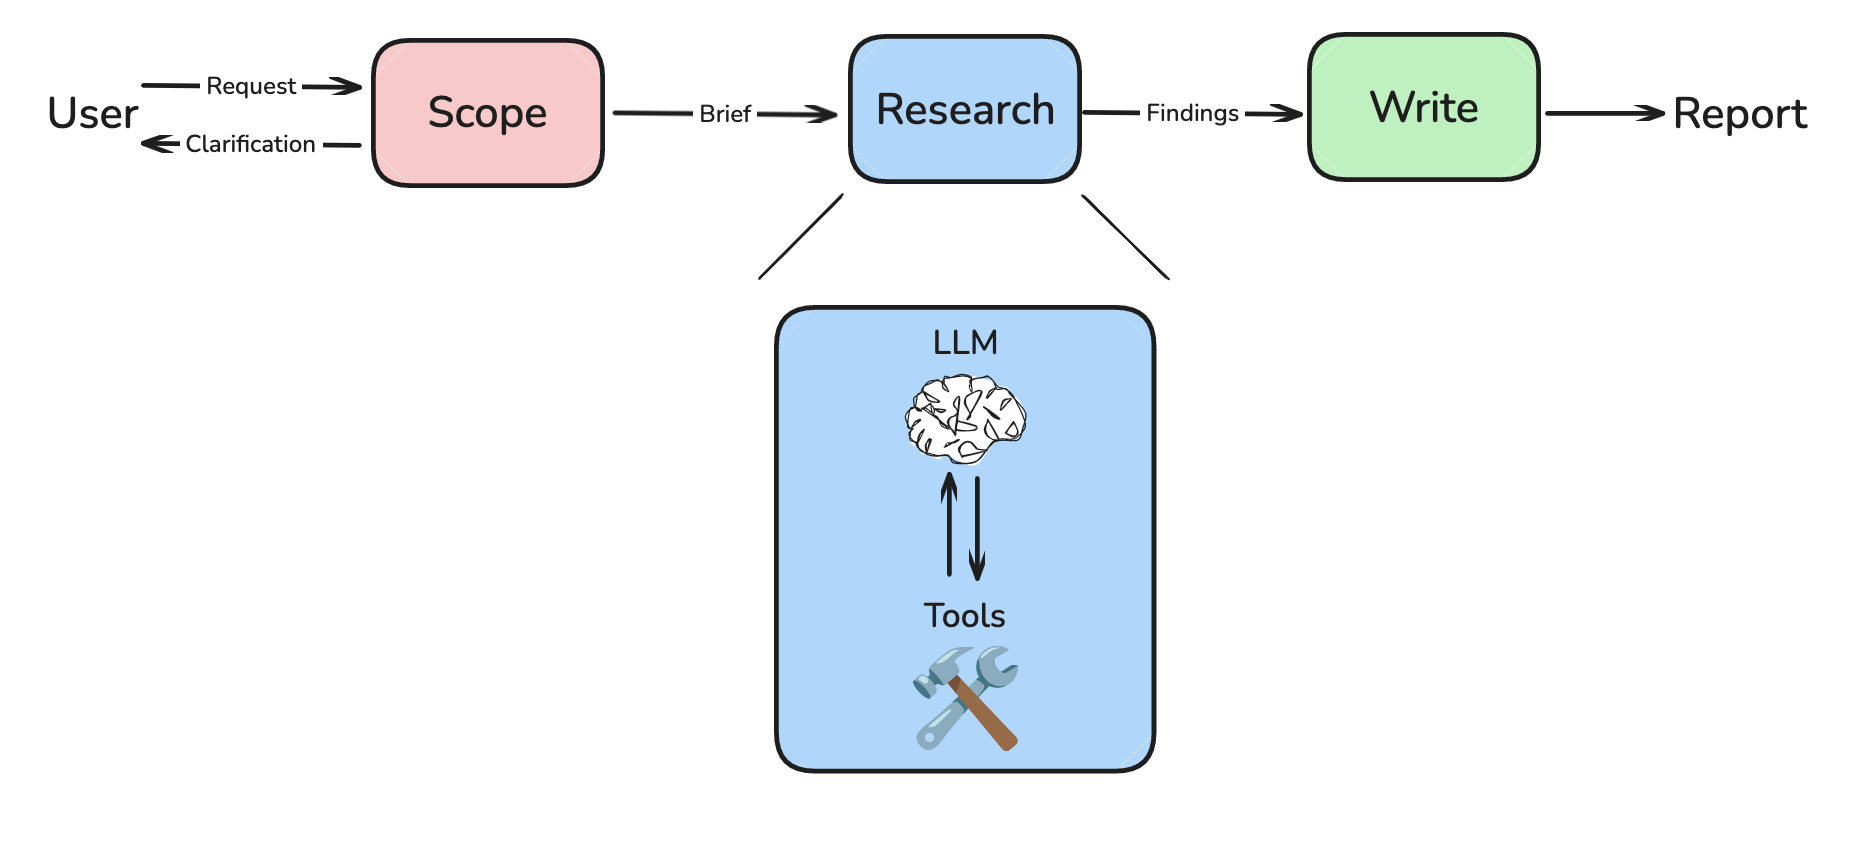

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [1]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import research_agent_prompt
Markdown(research_agent_prompt)

You are a research assistant conducting thorough research on user queries. Your goal is to provide comprehensive,  
well-sourced answers.                                                                                              

RESEARCH GUIDELINES:                                                                                               

 1 Use search tools to gather current and relevant information                                                     
 2 Search for multiple perspectives and sources when possible                                                      
 3 Cite sources clearly in your responses                                                                          
 4 Be thorough but efficient - don't make unnecessary searches                                                     
 5 If initial searches are insufficient, make additional targeted searches                                         

SEARCH STRATEGY:                                                                                                   

 • Start with broad searches to understand the topic                                                               
 • Follow up with specific searches for details or clarification                                                   
 • Look for authoritative sources and recent information                                                           
 • Consider different viewpoints and potential biases                                                              

RESPONSE FORMAT:                                                                                                   

 • Provide clear, well-structured answers                                                                          
 • Include specific facts and data points                                                                          
 • Cite sources using ]8;id=3126;URL\Source Name]8;;\ format                                                                           
 • Acknowledge limitations or uncertainties when appropriate                                                       

When you have enough information to provide a comprehensive answer, stop searching and provide your final response.

### State and Schemas

The state object and schema are similar to what we had in the previous notebook. 

We only add a schema, Summary, to store the summary of the search tool feedback. 


In [2]:
%%writefile ../src/deep_research_from_scratch/state.py

"""
State Definitions and Pydantic Schemas

This module defines the state objects and structured schemas used throughout
the research workflow for maintaining conversation context and structured output.
"""

from typing import Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

# ===== STATE DEFINITIONS =====

class AgentState(MessagesState):
    """
    Main state object for research workflow.
    
    Extends MessagesState to include conversation history plus
    the generated research brief for guiding research activities.
    """
    research_brief: Optional[str]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str
    key_excerpts: str

Overwriting ../src/deep_research_from_scratch/state.py


### Research Tool

Now, we'll define our research tool! 

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches. Tavily is a search engine optimized for AI applications, providing:
- Real-time web search results
- Content extraction and summarization
- Domain filtering and result ranking
- Async support for performance

####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

####  InjectedToolArg

The `InjectedToolArg` annotation allows us to inject runtime configuration into tools without exposing these parameters to the LLM. This is useful for:
- API keys and configuration
- Runtime settings (max_results, topic filters)
- System-level parameters the LLM shouldn't control

This keeps the tool interface clean for the LLM while allowing flexible configuration.

In [3]:
%%writefile ../src/deep_research_from_scratch/utils.py

"""
Research Utilities and Tools

This module provides search and content processing utilities for the research agent,
including async web search capabilities and content summarization tools.
"""

import asyncio
from datetime import datetime
from typing import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import AsyncTavilyClient

from deep_research_from_scratch.state import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== ASYNC SEARCH FUNCTIONS =====

async def tavily_search_async(
    search_queries: List[str], 
    max_results: int = 5, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
    config: RunnableConfig = None
) -> List[dict]:
    """
    Perform asynchronous search using Tavily API for multiple queries.
    
    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content
        config: Runtime configuration
        
    Returns:
        List of search result dictionaries
    """
    tavily_async_client = AsyncTavilyClient()
    
    # Create concurrent search tasks
    search_tasks = []
    for query in search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                max_results=max_results,
                include_raw_content=include_raw_content,
                topic=topic
            )
        )
    
    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)
    return search_docs

# ===== CONTENT PROCESSING =====

async def summarize_webpage(model: BaseChatModel, webpage_content: str) -> str:
    """
    Summarize webpage content using a language model.
    
    Args:
        model: Language model for summarization
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Use timeout to prevent hanging on slow responses
        summary = await asyncio.wait_for(
            model.ainvoke([HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))]),
            timeout=60.0
        )
        return f"""<summary>\n{summary.summary}\n</summary>\n\n<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"""
    except (asyncio.TimeoutError, Exception) as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content

# ===== RESEARCH TOOLS =====

TAVILY_SEARCH_DESCRIPTION = (
    "A search engine optimized for comprehensive, accurate, and trusted results. "
    "Useful for when you need to answer questions about current events."
)

@tool(description=TAVILY_SEARCH_DESCRIPTION)
async def tavily_search(
    queries: List[str],
    max_results: Annotated[int, InjectedToolArg] = 5,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
    config: RunnableConfig = None
) -> str:
    """
    Fetches results from Tavily search API with content summarization.

    Args:
        queries: List of search queries, you can pass in as many queries as you need
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')
        config: Runtime configuration

    Returns:
        Formatted string of search results with summaries
    """
    # Execute searches concurrently
    search_results = await tavily_search_async(
        queries,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
        config=config
    )
    
    # Deduplicate results by URL to avoid processing the same content multiple times
    formatted_output = f"Search results: \n\n"
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = {**result, "query": response['query']}
    
    # Set up summarization model for content processing
    summarization_model = init_chat_model("openai:gpt-4.1-mini").with_structured_output(Summary)
    
    async def noop():
        """No-op function for results without raw content."""
        return None
    
    # Create summarization tasks (only for pages with raw content)
    summarization_tasks = [
        noop() if not result.get("raw_content") else summarize_webpage(
            summarization_model, 
            result['raw_content'],
        )
        for result in unique_results.values()
    ]

    # Execute all summarization tasks concurrently
    summaries = await asyncio.gather(*summarization_tasks)
    
    # Create final results with summaries
    summarized_results = {
        url: {
            'title': result['title'], 
            'content': result['content'] if summary is None else summary
        }
        for url, result, summary in zip(unique_results.keys(), unique_results.values(), summaries)
    }

    # Format output with clear source separation
    for i, (url, result) in enumerate(summarized_results.items()):
        formatted_output += f"\n\n--- SOURCE {i+1}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "\n\n" + "-" * 80 + "\n"
    
    if summarized_results:
        return formatted_output
    else:
        return "No valid search results found. Please try different search queries or use a different search API."

Overwriting ../src/deep_research_from_scratch/utils.py


### Agent

Now, we'll define our agent.

#### Why Async is Useful for Research Agents

Research agents benefit significantly from async operations because:

- **Concurrent Search**: When searching multiple queries, we can run them concurrently instead of sequentially, dramatically reducing total execution time
- **Non-blocking I/O**: Web searches involve network calls that can be slow; async allows other operations to continue while waiting for responses
- **Scalability**: Async enables handling multiple research requests efficiently without blocking

#### Why We Use `await`

We use `await` for async method calls (`tool.ainvoke()`, `model.ainvoke()`) because:

- **Async Operations**: These methods perform I/O operations (API calls, model inference) that can take time
- **Non-blocking**: `await` allows other code to run while waiting for the operation to complete
- **Proper Sequencing**: Ensures the operation completes before proceeding to the next step
- **Error Handling**: Allows proper exception handling for async operations

For this, we need to convert our node functions to `async def` and use `await` for all async operations.

In [4]:
%%writefile ../src/deep_research_from_scratch/research_agent.py

"""
Research Agent Implementation

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions. The agent uses async operations
for concurrent search execution and includes tools for web search and content processing.
"""

import asyncio
import nest_asyncio
from typing_extensions import Literal

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from langchain.chat_models import init_chat_model
from IPython.display import Image, display

from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import research_agent_prompt

# ===== CONFIGURATION =====

# Enable nested event loops for Jupyter notebook compatibility
nest_asyncio.apply()

# Set up tools and model binding
tools = [tavily_search]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize model with tool binding
model = init_chat_model(model="openai:gpt-4.1")
model_with_tools = model.bind_tools(tools)

# ===== AGENT NODES =====

def llm_call(state: MessagesState):
    """
    LLM decision node.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """
    Tool execution node.
    
    Executes all tool calls from the previous LLM response concurrently.
    This is where the async benefits become apparent - multiple search queries
    can be executed simultaneously rather than sequentially.
    
    Returns updated state with tool execution results.
    """
    tool_calls = state["messages"][-1].tool_calls
    
    async def execute_tools():
        """Execute all tool calls concurrently for better performance."""
        # Create coroutines for all tool calls
        coros = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    messages = asyncio.run(execute_tools())
    return {"messages": messages}

# ===== ROUTING LOGIC =====

def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """
    Conditional routing function.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "environment": Continue to tool execution
        "__end__": Stop and return final answer
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "environment"
    # Otherwise, we have a final answer
    return "__end__"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(MessagesState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "environment": "environment",  # Continue research loop
        "__end__": END,               # Provide final answer
    },
)
agent_builder.add_edge("environment", "llm_call")  # Loop back for more research

# Compile the agent
agent = agent_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent.py


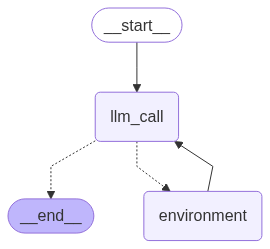

In [5]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.research_agent import agent
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent.ainvoke({"messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "queries": [                                                                                                  │
│     "best coffee shops in San Francisco 2025 based on coffee quality",                                          │
│     "Coffee Review highest rated coffee shops San Francisco",                                                   │
│     "Specialty Coffee Association certified cafes San Francisco 2025",                                          │
│     "Yelp top rated coffee shops San Francisco coffee quality July 2025",                                       │
│     "San Francisco coffee shops Google reviews focus on coffee quality July 2025"                               │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_fKh4Ubkd0W9UJuikKMSUZOGd                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Best Coffee San Francisco, CA - Last Updated July 2025 - Yelp ---                                 │
│ URL: https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA                               │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Top 10 Best Best Coffee in San Francisco, CA - July 2025 - Yelp - Paper Son Coffee, The Coffee Movement, Out    │
│ There Coffee Roasters, Sightglass Coffee,                                                                       │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: The Absolute Best San Francisco Coffee Shops - Eater SF ---                                       │
│ URL: https://sf.eater.com/maps/best-coffee-shops-san-francisco                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This article from Eater San Francisco highlights the top 16 coffee shops currently defining San Francisco's     │
│ vibrant coffee culture. The city is known as an influential hub in the coffee world, credited with pioneering   │
│ the "waves of coffee" terminology, introducing Yemeni coffee to the West Coast, and being the birthplace of     │
│ Irish Coffee and vacuum-sealed coffee. The list reflects recent changes, with Coffee Movement on Balboa Street, │
│ Poorboy Coffee, and Flywheel Coffee exiting, and Caffe Trieste, the Coffee Movement at Side A, and Cafe Shoji   │
│ joining. Featured shops include Saint Frank Coffee, known for its minimal aesthetic and Bolivian teas; Outset   │
│ Coffee, specializing in innovative fruit coffee blends; Scullery, serving specialty East Bay coffees in the     │
│ Tenderloin; Sextant Coffee Roasters, emphasizing direct trade and affordable quality; Telescope Coffee offering │
│ unique non-coffee drinks; Abanico Coffee Roasters, bringing specialty coffee with Latinx influences; SPRO,      │
│ known for inventive cocktails with coffee; Grand Coffee with multiple locations supporting community; Hey       │
│ Neighbor Cafe, popular for specialty toasts and community vibe; Excelsior Coffee highlighting diversity in the  │
│ coffee scene; Andytown Coffee Roasters, a beloved west side destination; Hi NRG, offering Hong Kong-inspired    │
│ coffee experiences; Paper Son blending Asian American h

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To provide a well-supported ranking of the best coffee shops in San Francisco specifically based on coffee      │
│ quality as of July 2025, I synthesized data from expert-focused review platforms, influential coffee            │
│ organizations, and major rating aggregators. Below is an evidence-based list, with each shop’s inclusion        │
│ corroborated by multiple reputable and/or primary sources focused on the quality of the coffee itself.          │
│                                                                                                                 │
│ ---                                                                                                             │
│ ## Top San Francisco Coffee Shops for Coffee Quality (as of July 2025)                                          │
│                                                                                                                 │
│ ### 1. **The Coffee Movement**                                                                                  │
│ - **Reputation:** Widely praised for exceptional coffee quality, expertise in extraction, and knowledgeable     │
│ baristas.                                                                                                       │
│ - **Evidence:** Top recommendations from The Infatuation [The                                                   │
│ Infatuation](https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco), Eater SF     │
│ [Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco), consistently appears at the top of Yelp  │
│ coffee quality rankings [Yelp](https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA).   │
│ - **Special Notes:** Known for creative seasonal drinks and high-scoring single-origin espresso beverages.      │
│                                                                                                                 │
│ ### 2. **Saint Frank Coffee**                                                                                   │
│ - **Reputation:** Celebrated for a minimal, coffee-centric approach; focuses on high transparency in sourcing   │
│ and excellent roasts.                                                                                           │
│ - **Evidence:** Featured in Eater SF's “defining” list, and consistently ranks among Yelp and Google’s best for │
│ taste and bean quality [Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco),                   │
│ [Yelp](https://m.yelp.com/search?find_desc=Best+Coffee+Shop&find_loc=San+Francisco%2C+CA).                      │
│ - **Special Notes:** Expanding locations, often highlighted by coffee professionals.                            │
│                                                                                                                 │
│ ### 3. **Andytown Coffee Roasters**                                                                             │
│ - **Reputation:** Revered for in-house roasted beans and consistently balanced espresso, especially from their  │
│ flagship Great Highway location.                                                                                │
│ - **Evidence:** Top marks from Reddit coffee forums, aggregated “best of” lists like Wanderlog                  │
│ [Wanderlog](https://wanderlog.com/list/geoCategory/17872/best-coffee-shops-and-best-cafes-in-san-francisco),    │
│ and highlighted by The Infatuation.                                                                             │
│ - **Special Notes:** Famous for Northern Irish soda bread and an ocean-adjacent café experience that doesn’t    │
│ compromise coffee quality.                                                                                      │
│                                                        

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent` in the dropdown menu:

```
"research_agent_mcp": "./src/deep_research_from_scratch/research_agent.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval (TODO: @nick Add eval brief v sources)

Eval 1 - 
* Input: supervisor messages list (can just be first message)
* Reference Output: Number of expected conduct research calls
* 1 evaluator
* Is the number of parallelism the same

Eval 2 - 
* Input: researcher chat history
* Reference Output: Call more tools or stop
* 1 evaluator
* boolean, did we stop when information was sufficient

## Lesson (TODO: @geoff review / improve)

In this notebook, we used Tavily search with summarization to compress the search results.

But there are many ways to improve this approach:

#### Prompt Engineering

```python
# Current approach
summarize_webpage_prompt = "Summarize this webpage..."
```

Try to improve the prompt to focus on the most important information, such as:

```
FOCUS ON:
- Key facts and statistics
- Expert opinions and authoritative sources
- Recent developments and trends
- Comparative information

EXTRACT:
- 3-5 most important points
- Relevant quotes with context
- Methodological details if applicable

IGNORE:
- Advertisements and promotional content
- Navigation and footer text
- Unrelated sidebar content
```

#### Model selection

Try other models for summarization. For example, you can choose from [this list](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html).

#### Heuristic Filtering

Try hard-coded filtering of the search results. For example, you can try things like:

```python
def filter_search_results(results, query_terms):
    """Apply heuristics to improve result quality"""
    filtered = []
    for result in results:
        # Content quality signals
        if len(result.get('content', '')) < 100:  # Too short
            continue
        if result.get('title', '').count('|') > 3:  # Likely spam
            continue
        
        # Relevance scoring
        relevance_score = calculate_relevance(result, query_terms)
        if relevance_score > 0.7:
            filtered.append(result)
    
    return sorted(filtered, key=lambda x: x.get('relevance_score', 0), reverse=True)
```

### Alternative Search APIs

Beyond Tavily, consider these search APIs for different use cases such as `DuckDuckGo`:

```python
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def duckduckgo_search(query: str, max_results: int = 5) -> str:
    """Privacy-focused search without tracking"""
    search = DuckDuckGoSearchRun()
    return search.run(query)
```

**Benefits:**
- No API key required
- Privacy-focused (no tracking)
- Good for general web search
- Free to use

**Limitations:**
- Rate limiting
- Less structured results
- No raw content extraction

#### Evals

Try adding your own eval examples! 

Test the ability of the native search tool (Tavily) or search tools you add to collect relevant sources! 